In [2]:
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.lines as lines
import sys
sys.path.insert(0, '..')
import occRateModels as rm
import occRateUtils as ut

In [3]:
def mstar_from_stellarprops(rstar, logg):
    """Gives stellar mass from the rstar and logg
       INPUT:
         rstar - Radius of star [Rsun]
         logg - log surface gravity [cgs]
       OUTPUT:
         mstar - stellar mass [Msun]
    """
    # Convert logg and rstar into stellar mass assuming logg_sun=4.437
    mstar = 10.0**logg * rstar**2. / 10.0**4.437
    return mstar

def earthflux_at_period(rstar, logg, teff, period):
    """Gives equivalent solar-earth bolometric flux for a given period
       INPUT:
         rstar - Radius of star [Rsun]
         logg - log surface gravity [cgs]
         teff - Effective Temperature [K]
         period - Orbital Period [day]
       OUTPUT:
         flx - Flux relative to sun-earth 
    """
    mstar = mstar_from_stellarprops(rstar, logg)
    # Calculate semi-major axis [AU]
    semia = mstar**(1.0/3.0) * (period/365.25)**(2.0/3.0)
    # Star bolometric luminosity in Lsun assuming teff_sun=5778.0
    lumstar = rstar**2.0 * (teff/5778.0)**4.0
    # Calculate solar earth bolometric flux ratio
    flx = lumstar / semia**2.0
    return flx

def period_at_earthflux(rstar, mstar, teff, seff):
    """Gives period for a given equivalent solar-earth bolometric flux
       INPUT:
         rstar - Radius of star [Rsun]
         mstar - stellar mass [Msun]
         teff - Effective Temperature [K]
         seff - insolation flux relative to sun-earth flux
       OUTPUT:
         period - Orbital period [days]
    """
    # Calculate semi-major axis [AU] assuming teff_sun=5778.0
    semia = rstar * (teff/5778.0)**2 / np.sqrt(seff)
    period = ( semia / (mstar**(1.0/3.0)) )**(3.0/2.0) * 365.25
    return period


def earthflux_at_semia(rstar, logg, teff, semia):
    """Gives equivalent solar-earth bolometric flux for a given period
       INPUT:
         rstar - Radius of star [Rsun]
         logg - log surface gravity [cgs]
         teff - Effective Temperature [K]
         semia - Orbital semi-major axis [AU]
       OUTPUT:
         flx - Flux relative to sun-earth 
    """
    mstar = mstar_from_stellarprops(rstar, logg)
    # Star bolometric luminosity in Lsun assuming teff_sun=5778.0
    lumstar = rstar**2.0 * (teff/5778.0)**4.0
    # Calculate solar earth bolometric flux ratio
    flx = lumstar / semia**2.0
    return flx

def semia_at_earthflux(rstar, teff, flx):
    """Gives equivalent solar-earth bolometric flux for a given period
       INPUT:
         rstar - Radius of star [Rsun]
         logg - log surface gravity [cgs]
         teff - Effective Temperature [K]
         flx - Flux relative to sun-earth
       OUTPUT:
         semia - Orbital semi-major axis [AU]
    """
    # Star bolometric luminosity in Lsun assuming teff_sun=5778.0
    lumstar = rstar**2.0 * (teff/5778.0)**4.0
    # Calculate solar earth bolometric flux ratio
    semia = np.sqrt(lumstar/flx)
    return semia


In [4]:
figDir = "summaryFigures"
stellarCatalog = "../stellarCatalogs/dr25_stellar_berger2020_clean_hab2.txt"
allStars = pd.read_csv(stellarCatalog)
# allStars = pd.read_csv("../stellarCatalogs/dr25_stellar_supp_gaia_clean_GKM.txt")
print("allStars has " + str(len(allStars)) + " stars")
allStars = allStars[allStars.teff < 7300];
print("allStars has " + str(len(allStars)) + " stars after restricting to FGKM")


allStars has 68885 stars
allStars has 68885 stars after restricting to FGKM


In [5]:
innerHZ = 1.8
outerHZ = 0.25
print("HZ flux: " + str(innerHZ) + " to " + str(outerHZ))

HZ flux: 1.8 to 0.25


In [6]:
innerHzPeriod = period_at_earthflux(allStars.iso_rad, allStars.iso_mass, allStars.iso_teff, innerHZ)
outerHzPeriod = period_at_earthflux(allStars.iso_rad, allStars.iso_mass, allStars.iso_teff, outerHZ)

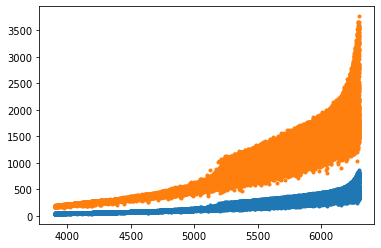

In [9]:
plt.plot(allStars.iso_teff, innerHzPeriod, '.')
plt.plot(allStars.iso_teff, outerHzPeriod, '.')

[  4.05515775 -12.408767  ]
[  5.75100936 -18.68782123]


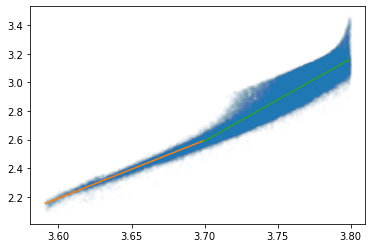

In [10]:
s1 = allStars.iso_teff<5000
s2 = allStars.iso_teff>5000
deltaHz = outerHzPeriod-innerHzPeriod
plt.plot(np.log10(allStars.iso_teff), np.log10(deltaHz), '.', alpha = 0.01)
pf1 = np.polyfit(np.log10(allStars[s1].iso_teff), np.log10(deltaHz[s1]), 
                1, w=1/(np.log10(allStars[s1].iso_teff_err1)))
pf2 = np.polyfit(np.log10(allStars[s2].iso_teff), np.log10(deltaHz[s2]), 
                1, w=1/(np.log10(allStars[s2].iso_teff_err1)))
x1 = np.linspace(np.min(np.log10(allStars.iso_teff)), np.log10(5000))
x2 = np.linspace(np.log10(5000), np.max(np.log10(allStars.iso_teff)))
rf1 = np.polyval(pf1, x1)
rf2 = np.polyval(pf2, x2)
plt.plot(x1,rf1)
plt.plot(x2,rf2)
print(pf1)
print(pf2)

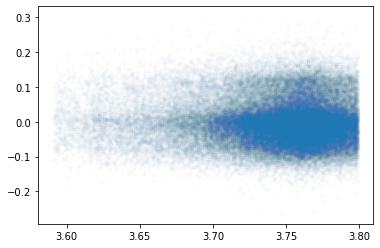

In [11]:
logResid1 = np.log10(deltaHz[s1]) - np.polyval(pf1, np.log10(allStars[s1].iso_teff))
logResid1 = logResid1.append(np.log10(deltaHz[s2]) - np.polyval(pf2, np.log10(allStars[s2].iso_teff)))
plt.plot(np.log10(allStars.iso_teff), logResid1, '.', alpha = 0.01)

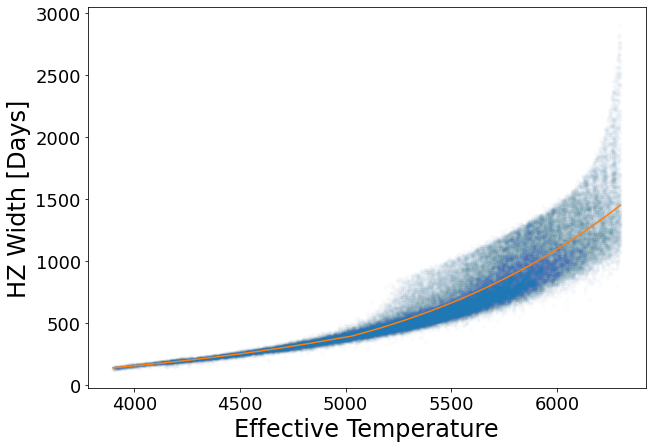

In [12]:
# import matplotlib
# matplotlib.rc('text', usetex = True)
# matplotlib.rc('font', **{'family' : "sans-serif"})

# params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
# plt.rcParams.update(params)

plt.figure(figsize=(10,7));
plt.plot(allStars.iso_teff, deltaHz, '.', alpha = 0.01)
x = np.linspace(np.min(allStars.iso_teff), np.max(allStars.iso_teff))
rf = 10**np.polyval(pf1, np.log10(x[x<5000]))
rf = np.append(rf, 10**np.polyval(pf2, np.log10(x[x>5000])))
plt.plot(x,rf)
plt.tick_params(labelsize = 18)
# plt.legend(["HZ Widths", r"$\begin{cases} T_\mathrm{eff}^{"+str(np.round(pf1[0],2))
#             +r"} & \text{if }T_\mathrm{eff}<5000, \\ T_\mathrm{eff}^{"+str(np.round(pf2[0],2))+r"} & \text{otherwise} \end{cases}$"], fontsize = 24)

plt.xlabel("Effective Temperature", fontsize = 24);
plt.ylabel("HZ Width [Days]", fontsize = 24);


In [13]:
str(np.round(pf1[0],2))

'4.06'

relResid: -0.012^{+0.162}_{-0.150}


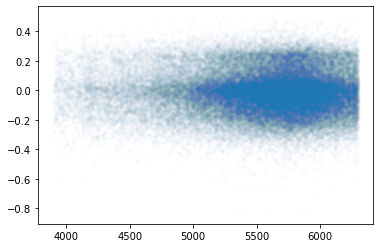

In [14]:
relResid = (np.array(deltaHz[s1])-10**np.polyval(pf1, np.log10(allStars[s1].iso_teff)))/np.array(deltaHz[s1])
relResid = np.append(relResid, (np.array(deltaHz[s2])-10**np.polyval(pf2, np.log10(allStars[s2].iso_teff)))/np.array(deltaHz[s2]))
plt.plot(allStars.iso_teff, relResid, '.', alpha=0.01);
print("relResid: " + ut.printMedianAndErrorbars(relResid))

relResid: -5.162^{+158.508}_{-108.977}


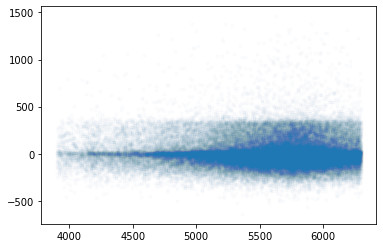

In [15]:
resid = (np.array(deltaHz[s1])-10**np.polyval(pf1, np.log10(allStars[s1].iso_teff)))
resid = np.append(resid, (np.array(deltaHz[s2])-10**np.polyval(pf2, np.log10(allStars[s2].iso_teff))))
plt.plot(allStars.iso_teff, resid, '.', alpha=0.01);
print("relResid: " + ut.printMedianAndErrorbars(resid))

In [34]:
# semi-axis spacing
for s in stellarCatalog:
    innerHzSemia = semia_at_earthflux(allStars.iso_rad, allStars.iso_teff, innerHZ)
    outerHzSemia = semia_at_earthflux(allStars.iso_rad, allStars.iso_teff, outerHZ)

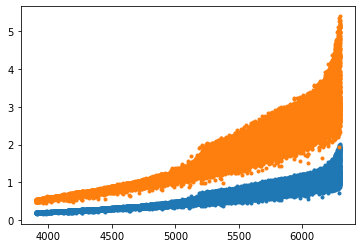

In [17]:
plt.plot(allStars.iso_teff, innerHzSemia, '.');
plt.plot(allStars.iso_teff, outerHzSemia, '.');

[  3.16231805 -11.83896749]
[  4.49138301 -16.76857699]


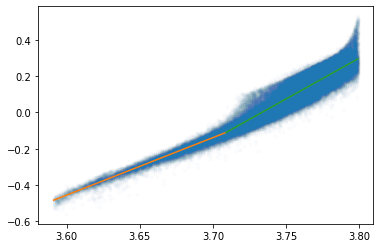

In [15]:
teffBreak = 5117
s1 = allStars.iso_teff<teffBreak
s2 = allStars.iso_teff>teffBreak
deltaSemia = outerHzSemia-innerHzSemia
plt.plot(np.log10(allStars.iso_teff), np.log10(deltaSemia), '.', alpha = 0.01)
pf1 = np.polyfit(np.log10(allStars[s1].iso_teff), np.log10(deltaSemia[s1]), 
                1, w=1/(np.log10(allStars[s1].iso_teff_err1)))
pf2 = np.polyfit(np.log10(allStars[s2].iso_teff), np.log10(deltaSemia[s2]), 
                1, w=1/(np.log10(allStars[s2].iso_teff_err1)))
x1 = np.linspace(np.min(np.log10(allStars.iso_teff)), np.log10(teffBreak))
x2 = np.linspace(np.log10(teffBreak), np.max(np.log10(allStars.iso_teff)))
rf1 = np.polyval(pf1, x1)
rf2 = np.polyval(pf2, x2)
plt.plot(x1,rf1)
plt.plot(x2,rf2)
print(pf1)
print(pf2)

In [16]:
print(10**pf1[1]*teffBreak**pf1[0])
print(10**pf2[1]*teffBreak**pf2[0])

0.7764597190005209
0.7763040046510669


relResid: -0.003^{+0.053}_{-0.045}


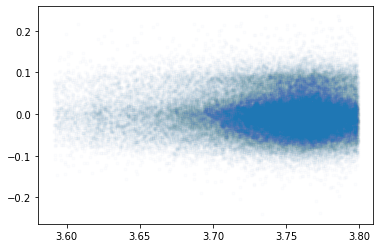

In [17]:
logResid1 = np.log10(deltaSemia[s1]) - np.polyval(pf1, np.log10(allStars[s1].iso_teff))
logResid1 = logResid1.append(np.log10(deltaSemia[s2]) - np.polyval(pf2, np.log10(allStars[s2].iso_teff)))
plt.plot(np.log10(allStars.iso_teff), logResid1, '.', alpha = 0.01);
print("relResid: " + ut.printMedianAndErrorbars(logResid1))

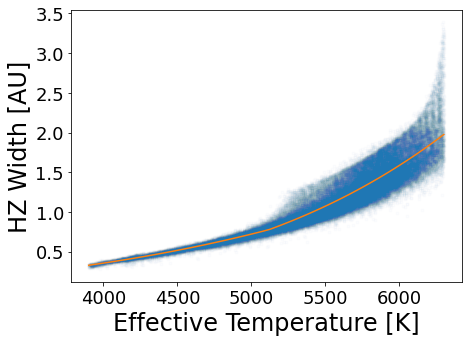

In [18]:

plt.figure(figsize=(7,5));
plt.plot(allStars.iso_teff, deltaSemia, '.', alpha = 0.01)
x = np.linspace(np.min(allStars.iso_teff), np.max(allStars.iso_teff))
rf = 10**np.polyval(pf1, np.log10(x[x<teffBreak]))
rf = np.append(rf, 10**np.polyval(pf2, np.log10(x[x>teffBreak])))
plt.plot(x,rf)
plt.tick_params(labelsize = 18)
# plt.legend(["HZ Widths", r"$\begin{cases} T_\mathrm{eff}^{"+str(np.round(pf1[0],2))
#             +r"} & \text{if }T_\mathrm{eff}<"+ str(teffBreak) + r", \\ T_\mathrm{eff}^{"
#             +str(np.round(pf2[0],2))+r"} & \text{otherwise} \end{cases}$"], fontsize = 24)

plt.xlabel("Effective Temperature [K]", fontsize = 24);
plt.ylabel("HZ Width [AU]", fontsize = 24);


relResid: -0.006^{+0.115}_{-0.109}


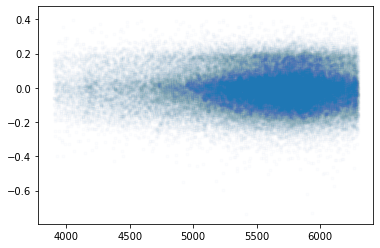

In [19]:
relResid = (np.array(deltaSemia[s1])-10**np.polyval(pf1, np.log10(allStars[s1].iso_teff)))/np.array(deltaSemia[s1])
relResid = np.append(relResid, (np.array(deltaSemia[s2])-10**np.polyval(pf2, np.log10(allStars[s2].iso_teff)))/np.array(deltaSemia[s2]))
plt.plot(allStars.iso_teff, relResid, '.', alpha=0.01);
print("relResid: " + ut.printMedianAndErrorbars(relResid))

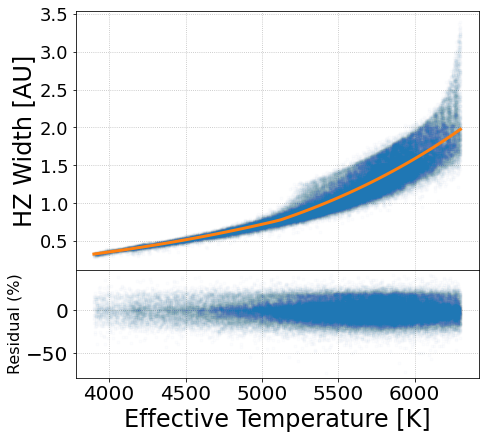

In [24]:
fig1 = plt.figure(figsize=(7,6));
frame1=fig1.add_axes((.1,.35,.8,.6))
plt.plot(allStars.iso_teff, deltaSemia, '.', alpha = 0.01)
x = np.linspace(np.min(allStars.iso_teff), np.max(allStars.iso_teff))
rf = 10**np.polyval(pf1, np.log10(x[x<teffBreak]))
rf = np.append(rf, 10**np.polyval(pf2, np.log10(x[x>teffBreak])))
plt.plot(x,rf,lw=3)
plt.tick_params(labelsize = 18)
plt.grid(ls=":", alpha=0.9);
# plt.legend(["HZ Widths", r"$\begin{cases} T_\mathrm{eff}^{"+str(np.round(pf1[0],2))
#             +r"} & \text{if }T_\mathrm{eff}<"+ str(teffBreak) + r", \\ T_\mathrm{eff}^{"
#             +str(np.round(pf2[0],2))+r"} & \text{otherwise} \end{cases}$"], fontsize = 24)
plt.ylabel("HZ Width [AU]", fontsize = 24);

frame2=fig1.add_axes((.1,.1,.8,.25))        
plt.plot(allStars.iso_teff, 100*relResid, '.', alpha=0.01);
plt.tick_params(labelsize = 20)
plt.grid(ls=":", alpha=0.9);

plt.xlabel("Effective Temperature [K]", fontsize = 24);
plt.ylabel("Residual (%)", fontsize = 16);
plt.savefig(figDir + "/hzWidth.png",bbox_inches='tight')


In [27]:
allStars

,kepid,tm_designation,teff,teff_err1,teff_err2,logg,logg_err1,logg_err2,feh,feh_err1,...,logg_DR25,logg_DR25_err1,logg_DR25_err2,feh_DR25,feh_DR25_err1,feh_DR25_err2,limbdark_coeff1_DR25,limbdark_coeff2_DR25,limbdark_coeff3_DR25,limbdark_coeff4_DR25
0,10000800,2MASS J19065751+4657575,5362.790997,96.077786,92.381055,4.493869,0.039715,0.047158,-0.008651,0.135345,...,4.547,0.035,-0.184,-0.04,0.30,-0.30,0.5107,0.0402,0.4845,-0.2827
1,10000827,2MASS J19065980+4657282,5390.030248,98.412541,94.178433,4.432616,0.041901,0.043897,0.164622,0.133964,...,4.559,0.038,-0.162,-0.10,0.30,-0.30,0.4983,0.0703,0.4526,-0.2695
2,10000876,2MASS J19070870+4657343,5118.260934,88.513015,80.122690,4.493281,0.037809,0.031151,0.050301,0.133487,...,4.410,0.132,-0.198,0.18,0.20,-0.25,0.6581,-0.5152,1.1843,-0.5207
3,10000941,2MASS J19071664+4654420,4871.837730,74.785174,70.391382,4.580680,0.017029,0.026598,0.123273,0.110771,...,4.477,0.095,-0.105,0.08,0.25,-0.25,0.6428,-0.5256,1.2195,-0.5287
4,10000962,2MASS J19071924+4654297,5299.518224,94.373535,89.349202,4.557722,0.022931,0.036059,-0.128649,0.127084,...,4.592,0.036,-0.135,-0.24,0.30,-0.30,0.4854,0.0383,0.5476,-0.3170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68880,9992793,2MASS J18475485+4659507,6101.373644,115.802281,115.243048,4.309575,0.051215,0.054468,-0.016879,0.152719,...,4.421,0.054,-0.229,0.07,0.25,-0.30,0.4232,0.5307,-0.2861,0.0440
68881,9992816,2MASS J18475850+4656386,5847.701145,101.879362,99.151527,4.464258,0.025696,0.038045,-0.087576,0.128066,...,4.520,0.044,-0.187,-0.16,0.30,-0.30,0.4050,0.4571,-0.0924,-0.0503
68882,9999784,2MASS J19042910+4658254,5315.223509,102.615917,92.478012,4.460622,0.049329,0.047518,0.026089,0.141294,...,4.559,0.030,-0.170,0.07,0.25,-0.30,0.5695,-0.1605,0.7353,-0.3736
68883,9999869,2MASS J19043972+4657400,5881.869860,97.423505,96.483719,4.473559,0.020181,0.030934,-0.103952,0.113453,...,4.450,0.070,-0.224,-0.10,0.25,-0.35,0.4017,0.5284,-0.2349,0.0169


In [28]:
np.min(allStars[(allStars.teff > 4800)&(allStars.teff <6300)].radius)

0.551385718965

In [29]:
np.max(allStars[(allStars.teff > 4800)&(allStars.teff <6300)].radius)

2.27273921819

In [32]:
np.percentile(allStars[(allStars.teff > 4800)&(allStars.teff <6300)].radius, 99)

1.621493077410399

0        0.914012
1        0.914012
2        0.914012
3        0.914012
4        0.914012
           ...   
68880    0.914012
68881    0.914012
68882    0.914012
68883    0.914012
68884    0.914012
Length: 68885, dtype: float64

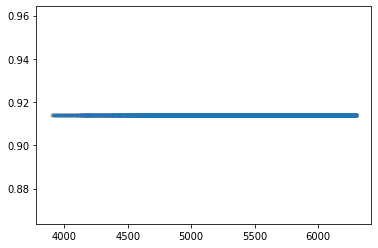

In [38]:
deltaSemia = outerHzSemia-innerHzSemia
meanSemia = (outerHzSemia+innerHzSemia)/2
daOvera = deltaSemia/meanSemia
plt.plot(allStars.iso_teff, daOvera, '.', alpha = 0.01)
daOvera

[-8.80865222e-17  3.01029996e-01]
[-1.22767517e-16  3.01029996e-01]


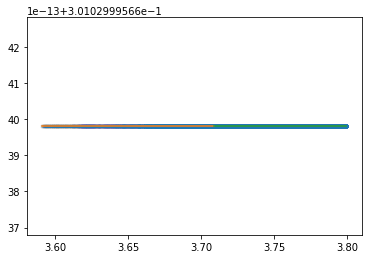

In [18]:
teffBreak = 5117
s1 = allStars.iso_teff<teffBreak
s2 = allStars.iso_teff>teffBreak
deltaSemia = outerHzSemia-innerHzSemia
meanSemia = (outerHzSemia-innerHzSemia)/2
daOvera = deltaSemia/meanSemia
plt.plot(np.log10(allStars.iso_teff), np.log10(daOvera), '.', alpha = 0.01)
pf1 = np.polyfit(np.log10(allStars[s1].iso_teff), np.log10(daOvera[s1]), 
                1, w=1/(np.log10(allStars[s1].iso_teff_err1)))
pf2 = np.polyfit(np.log10(allStars[s2].iso_teff), np.log10(daOvera[s2]), 
                1, w=1/(np.log10(allStars[s2].iso_teff_err1)))
x1 = np.linspace(np.min(np.log10(allStars.iso_teff)), np.log10(teffBreak))
x2 = np.linspace(np.log10(teffBreak), np.max(np.log10(allStars.iso_teff)))
rf1 = np.polyval(pf1, x1)
rf2 = np.polyval(pf2, x2)
plt.plot(x1,rf1)
plt.plot(x2,rf2)
print(pf1)
print(pf2)

In [32]:
r1 = np.random.rand(100)
r2 = np.random.rand(100)
dr = r1 - r2
mr = (r1 + r2)/2
rr = dr/mr
rr

array([-0.78615632, -1.94544373, -0.08760663, -0.84541083, -0.28290493,
       -0.63163486, -0.80564185, -0.19855762, -1.40847281, -0.347754  ,
        0.01641001, -0.0558359 , -1.55576275, -1.5834196 ,  0.20619897,
        1.36717454, -0.91759808, -0.73471997,  1.12408857,  1.41470908,
       -1.60798261, -0.25798009, -1.14538597, -0.2380611 ,  0.70008544,
        1.64944745,  1.05338829, -0.03287736, -1.17619208, -1.1593532 ,
        0.87945722,  1.74120121, -1.4018632 , -0.36321324, -1.76046353,
        0.08004522, -0.10656658, -0.85428874,  0.74618376, -1.06899455,
       -0.75944147,  0.73522846, -0.10564105,  1.34271629,  0.08753918,
       -0.68406482, -0.22683681,  0.25511534,  1.86045549,  0.68351975,
        0.96491129,  0.33862493,  1.85524845, -0.7161847 ,  0.91931632,
        1.45235284,  1.46258713, -0.38266204,  0.29443139, -0.72587094,
       -1.07925318, -0.85723496,  0.78394052, -0.20138431,  0.71891898,
        1.87117072, -0.95339534,  0.5338111 ,  1.26415337,  0.88

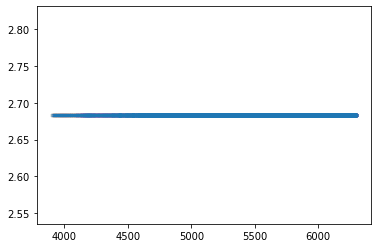

In [35]:
plt.plot(allStars.iso_teff, outerHzSemia/innerHzSemia, '.', alpha = 0.01)

In [36]:
outerHzSemia/innerHzSemia

0        2.683282
1        2.683282
2        2.683282
3        2.683282
4        2.683282
           ...   
68880    2.683282
68881    2.683282
68882    2.683282
68883    2.683282
68884    2.683282
Length: 68885, dtype: float64

In [37]:
2*(1-2.683282)/(1+2.683282)

-0.914012014285086

In [40]:
innerHZ

1.8

In [41]:
outerHZ

0.25

In [44]:
innerHZ - outerHZ

1.55

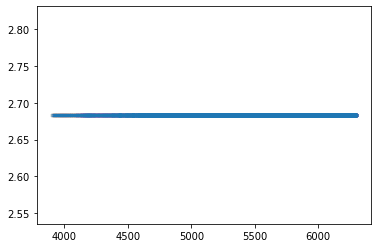

In [42]:
lumstar = allStars.radius**2.0 * (allStars.teff/5778.0)**4.0
# Calculate solar earth bolometric flux ratio
semiaIn = np.sqrt(lumstar/innerHZ)
semiaOut = np.sqrt(lumstar/outerHZ)
plt.plot(allStars.iso_teff, semiaOut/semiaIn, '.', alpha = 0.01)

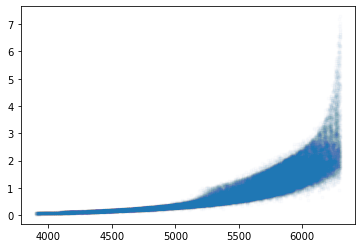

In [43]:
plt.plot(allStars.iso_teff, lumstar, '.', alpha = 0.01)